# Libs

In [1]:
from cucim import skimage as skimage ## use this GPU-powered version of skimage for most things 
import skimage as sk ## only needed for skimage.io

## Test for GPU devices
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import os
import re
import json
import sys
from itertools import chain
# sys.path.append('/data/srlab/ik936/Spatial/python/')
# from utils_spatial import *

# import czifile as zis
import numpy as np
import matplotlib.pyplot as plt
import tifffile
# from aicsimageio import AICSImage
import pandas as pd
# import skimage

# from skimage import exposure
# from skimage import filters
# from skimage import color

import deepcell
# from skimage.io import imread
from deepcell.applications import Mesmer
# from skimage import measure

def fig_size(h, w):   
    plt.rcParams['figure.figsize'] = [w, h]


from tifffile import TiffFile
import xml.etree.ElementTree as ET
import re



2022-02-27 12:07:51.108110: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-27 12:07:57.745010: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-27 12:07:59.900944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla M40 computeCapability: 5.2
coreClock: 1.112GHz coreCount: 24 deviceMemorySize: 11.18GiB deviceMemoryBandwidth: 268.58GiB/s
2022-02-27 12:07:59.900996: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-27 12:07:59.901083: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-27 12:07:59.901126: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Functions

## Segmentation

In [2]:
## min_dna_intensity is a heuristic to avoid segmenting empty images 
def do_pipeline(img, libname, channels, channels_dna, channels_cells, outdir, max_size=2048, min_dna_intensity=1e9):
    ## Get subimage coords
    subimage_coords = get_subimage_coords(img.shape, max_size)
    print(subimage_coords)

    ## Initialize data structures for full image 
    mask = np.zeros(shape=(img.shape[1], img.shape[2]), dtype=int)
    ncells = 0
    metadata = pd.DataFrame(columns=[
        'x', 'y', 'convex_area', 'area', 'solidity', 'major_axis_length',
        'orientation', 'minor_axis_length', 'extent', 'perimeter',
        'equivalent_diameter', 'euler_number', 'eccentricity'
    ])
    intensities = pd.DataFrame(columns=channels)
    mesmer_app = Mesmer()  
    idx_dna = [i for i, c in enumerate(channels) if c in channels_dna]

    ## For each subimage, do 
    for i in range(subimage_coords.shape[0]):
        print(i, '---------------------------')
        r0, r1 =subimage_coords.row_start[i], subimage_coords.row_end[i]
        c0, c1 =subimage_coords.col_start[i], subimage_coords.col_end[i]
        subimg = img[:, r0:r1, c0:c1]
        if (subimg[idx_dna, :, :].sum() < min_dna_intensity):
            continue 

        ## pre-processing
        subimg_processed = do_preprocess(subimg)

        ## collapsing
        subimg_collapsed = collapse_channels(subimg_processed, channels, channels_dna, channels_cells)

        ## segmentation
        _mask = do_mesmer(mesmer_app, subimg_collapsed)
        if (_mask.max() < 1): 
            ## Found no cells in this subimage 
            continue 
        _mask[_mask>0]=_mask[_mask>0]+ncells
        mask[r0:r1, c0:c1]=_mask
        ncells+=len(np.unique(_mask))-1

        ## quantify regions
        ## if we do this in the subimage, we can use normalized data 
        ## UPDATE: do not use CLAHE normalized data to quantify signal in cells 
        _metadata, _intensities = quant_cells(_mask, subimg, channels)
        _metadata.x += r0
        _metadata.y += c0
        metadata = pd.concat([metadata, _metadata])    
        intensities = pd.concat([intensities, _intensities])    

    ## Save final results 
    np.savetxt('{}/{}_mask.csv'.format(outdir, libname), mask, fmt='%d')
    metadata.to_csv('{}/{}_metadata.csv'.format(outdir, libname))
    intensities.to_csv('{}/{}_intensity.csv'.format(outdir, libname))


def get_subimage_coords(img_shape, max_size): 
    subimage_coords=list()
    for row in range(int(np.ceil(img_shape[1] / max_size))): 
        r0, r1 = row * max_size, (row+1)*max_size
        for col in range(int(np.ceil(img_shape[2] / max_size))): 
            c0, c1 = col * max_size, (col+1)*max_size
            subimage_coords.append([r0, r1, c0, c1])
    subimage_coords = pd.DataFrame(subimage_coords, columns=['row_start', 'row_end', 'col_start', 'col_end'])
    return subimage_coords


## For now, just do CLAHE 
## May want 99.9% scaling later 
def do_preprocess(img):
    res = np.ndarray(shape=img.shape, dtype=np.float64)
    for i in range(img.shape[0]):
        res[i, :, :] = skimage.exposure.equalize_adapthist(img[i, :, :], kernel_size=None, clip_limit=0.01, nbins=256).get() ## cuCIM (gpu)
        # res[i, :, :] = skimage.exposure.equalize_adapthist(img[i, :, :], kernel_size=None, clip_limit=0.01, nbins=256) ## regular skimage (cpu)
    return res


def do_mesmer(app, img):
    img = np.expand_dims(np.transpose(img, [1, 2, 0]), 0)
    mask_wc = app.predict(img, compartment='whole-cell')[0, :, :, 0]
    return mask_wc


def collapse_channels(img, channel_names, channels_nucleus, channels_surface, do_log=False, do_scale=False): 
    if (do_log):
        img = np.log1p(img)
    
    if (do_scale): 
        img = img.astype('float64')
        for i in range(img.shape[0]):
            _img = img[i, :, :]
            img[i, :, :] = np.interp(_img, (_img.min(), _img.max()), (0, 1))

    
    ## Collapse into 2-channel tiff
    img_out = np.stack([
        np.sum(img[[i for i in range(img.shape[0]) if channel_names[i] in channels_nucleus], :, :], 0),
        # img[[i for i in range(img.shape[0]) if channel_names[i] in channels_nucleus][0], :, :],
        np.sum(img[[i for i in range(img.shape[0]) if channel_names[i] in channels_surface], :, :], 0)
    ], 0)
    
    if (do_scale):
        ## Rescale after sum 
        for i in range(img_out.shape[0]):
            _img = img_out[i, :, :]
            img_out[i, :, :] = np.interp(_img, (_img.min(), _img.max()), (0, 1))
    
    return(img_out)

## get area from regions 
def quant_cells(mask, img, channels): 
    ## Intensity must be measured one channel at a time 
    def get_regions(i):
        regions = sk.measure.regionprops(label_image=mask, intensity_image=img[i, :, :])
        res = pd.DataFrame([r.intensity_image.sum() for r in regions])
        return(res)

    x = [get_regions(i) for i in range(img.shape[0])]
    X = pd.concat(x, axis=1)
    X.columns = channels

    ## Pure morphology information (w/o intensity)
    regions=sk.measure.regionprops(label_image=mask)
    x = [
        pd.DataFrame(
            [[r.centroid[0], r.centroid[1], r.convex_area, r.area, r.solidity, r.major_axis_length, r.orientation, r.minor_axis_length, r.extent, r.perimeter, r.equivalent_diameter, r.euler_number, r.eccentricity]], 
            columns = ['x', 'y', 'convex_area', 'area', 'solidity', 'major_axis_length', 'orientation', 'minor_axis_length', 'extent', 'perimeter', 'equivalent_diameter', 'euler_number', 'eccentricity']
        ) for r in regions
    ]
    metadata = pd.concat(x, axis=0)
    metadata.index = X.index

    return metadata, X

## I/O and plotting

In [3]:
def plot_rgb(img, channels_plot, channels, h=6, w=8):
    if (len(channels_plot) != 3): 
        print('Must select 3 channels to plot in RGB')
        return
    
    fig_size(h, w)    
    idx = [i for i, name in enumerate(channels) if name in channels_plot] 
    img = img[idx, :, :]
    img = img.astype('float64')
    # img_sub = np.log1p(img_sub)
    for i in range(img.shape[0]):
        _img = img[i, :, :]
        img[i, :, :] = np.interp(_img, (_img.min(), _img.max()), (0, 1))

    sk.io.imshow(np.transpose(img, [1, 2, 0]))
    

def plot_multichannel_hist(img, names, min_val, nbin, rows=1):
    cols=int(np.ceil(img.shape[0] / rows))
    axes=[]
    fig=plt.figure()
    plt.rcParams['figure.figsize'] = [3*cols, 4*rows]
    for a in range(img.shape[0]): 
        axes.append(fig.add_subplot(rows, cols, a+1))
        axes[-1].set_title(names[a])
        x=img[a].flatten()
        x=x[np.where(x > min_val)]
        plt.hist(x, bins=nbin);      
    fig.tight_layout()    
    plt.show()

    
def read_img(img_fname): 
    img = tifffile.imread(img_fname)
    tif = TiffFile(img_fname)
    root = ET.fromstring(tif.ome_metadata)
    channels = [i.items()[1][1] for i in root.iter() if re.search('Channel', i.tag)]
    return img, channels 


# Process images 

## GUT 6846

In [15]:
%%time 
img, channels = read_img('/n/scratch3/users/i/ik97/GI_6846_region_001.ome.tiff')
img = img[:, 1000:7800, 800:6000]

CPU times: user 22.3 s, sys: 3.77 s, total: 26 s
Wall time: 26.2 s


In [16]:
# %%time 
# plot_rgb(img[:, :, 0:6300], ['PANCK', 'VIMENTIN', 'DAPI_FINAL'], channels)


In [17]:
%%time
do_pipeline(
    img, 
    libname = 'GI6846',
    channels = channels, 
    channels_dna = ['DAPI_FINAL'],
    channels_cells = [
        'ACTA2', 'CD14', 'CD146', 'CD3', 'CD31', 
        'CD4', 'CD45', 'CD68', 'CD8', 'PANCK',
        'PDGFRA', 'PDPN', 'THY1', 'VIMENTIN'
    ],
    outdir = '/home/ik97/Roche/data/CellDive/results/'
)

    row_start  row_end  col_start  col_end
0           0     2048          0     2048
1           0     2048       2048     4096
2           0     2048       4096     6144
3        2048     4096          0     2048
4        2048     4096       2048     4096
5        2048     4096       4096     6144
6        4096     6144          0     2048
7        4096     6144       2048     4096
8        4096     6144       4096     6144
9        6144     8192          0     2048
10       6144     8192       2048     4096
11       6144     8192       4096     6144


2022-02-23 16:23:22.221627: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-23 16:23:22.222574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-02-23 16:23:22.223750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2022-02-23 16:23:22.223815: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-23 16:23:22.899119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnec

0 ---------------------------


2022-02-23 16:23:36.339302: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-23 16:23:36.340092: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2022-02-23 16:23:37.217050: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-02-23 16:23:37.658783: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-02-23 16:23:38.721947: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-23 16:23:39.088890: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


1 ---------------------------
2 ---------------------------
3 ---------------------------
4 ---------------------------
5 ---------------------------
6 ---------------------------
7 ---------------------------
8 ---------------------------
9 ---------------------------
10 ---------------------------
11 ---------------------------
CPU times: user 2min 12s, sys: 19 s, total: 2min 31s
Wall time: 2min 41s


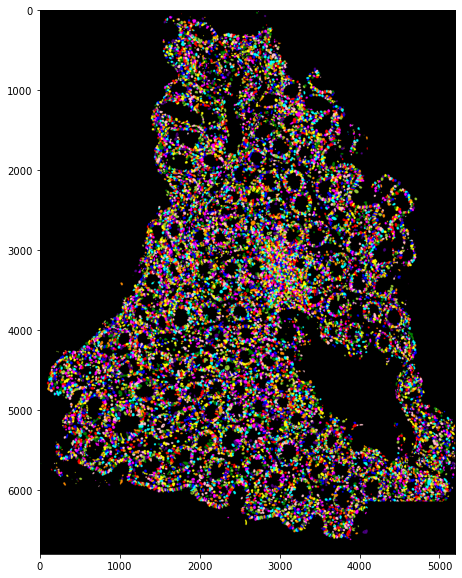

In [18]:
mask = np.loadtxt('../../data/CellDive/results/GI6846_mask.csv')
fig_size(10, 16)
plt.imshow(sk.color.label2rgb(mask, bg_label=0));


## Gut 6717


In [19]:
%%time 
img, channels = read_img('/n/scratch3/users/i/ik97/GI_6717_3_region_001.ome.tiff')

CPU times: user 37.1 s, sys: 6.27 s, total: 43.4 s
Wall time: 43.7 s


In [20]:
# # %%time 
# plot_rgb(img, ['CK8', 'VIM', 'DAPI_FINAL'], channels)


In [21]:
%%time
do_pipeline(
    img, 
    libname = 'GI6717',
    channels = channels, 
    channels_dna = ['DAPI_FINAL'],
    channels_cells = ['ASMA', 'CD146', 'CD3', 'CD31', 'CD4', 'CD45', 'CD68', 'CD8', 'CD90', 'CK8', 'PDGFRA', 'PDPN', 'VIM'],
    outdir = '/n/scratch3/users/i/ik97/results/'
)


    row_start  row_end  col_start  col_end
0           0     2048          0     2048
1           0     2048       2048     4096
2           0     2048       4096     6144
3           0     2048       6144     8192
4           0     2048       8192    10240
5           0     2048      10240    12288
6           0     2048      12288    14336
7        2048     4096          0     2048
8        2048     4096       2048     4096
9        2048     4096       4096     6144
10       2048     4096       6144     8192
11       2048     4096       8192    10240
12       2048     4096      10240    12288
13       2048     4096      12288    14336
14       4096     6144          0     2048
15       4096     6144       2048     4096
16       4096     6144       4096     6144
17       4096     6144       6144     8192
18       4096     6144       8192    10240
19       4096     6144      10240    12288
20       4096     6144      12288    14336
21       6144     8192          0     2048
22       61

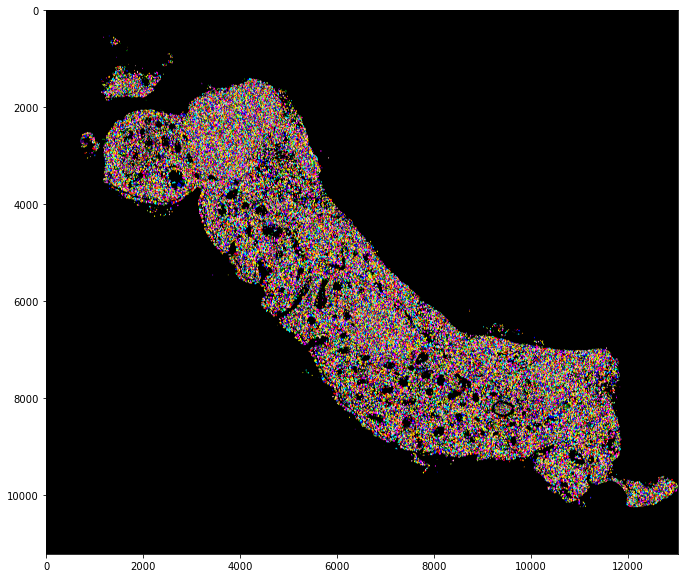

In [22]:
mask = np.loadtxt('../../data/CellDive/results/GI6717_mask.csv')
fig_size(10, 16)
plt.imshow(sk.color.label2rgb(mask, bg_label=0));


## Gut 6645

In [23]:
%%time 
img, channels = read_img('/n/scratch3/users/i/ik97/GI_6645_region_001.ome.tiff')

CPU times: user 23 s, sys: 3.99 s, total: 27 s
Wall time: 27.2 s


In [24]:
# %%time 
# plot_rgb(img[:, :, 0:6300], ['PANCK', 'VIMENTIN', 'DAPI_FINAL'], channels)


In [25]:
%%time
do_pipeline(
    img[:, :, :6300], 
    libname = 'GI6645',
    channels = channels, 
    channels_dna = ['DAPI_FINAL'],
    channels_cells = [
        'ACTA2', 'CD14', 'CD146', 'CD3', 'CD31', 
        'CD4', 'CD45', 'CD68', 'CD8', 'PANCK',
        'PDGFRA', 'PDPN', 'THY1', 'VIMENTIN'
    ],
    outdir = '/n/scratch3/users/i/ik97/results/'
)


    row_start  row_end  col_start  col_end
0           0     2048          0     2048
1           0     2048       2048     4096
2           0     2048       4096     6144
3           0     2048       6144     8192
4        2048     4096          0     2048
5        2048     4096       2048     4096
6        2048     4096       4096     6144
7        2048     4096       6144     8192
8        4096     6144          0     2048
9        4096     6144       2048     4096
10       4096     6144       4096     6144
11       4096     6144       6144     8192
12       6144     8192          0     2048
13       6144     8192       2048     4096
14       6144     8192       4096     6144
15       6144     8192       6144     8192
16       8192    10240          0     2048
17       8192    10240       2048     4096
18       8192    10240       4096     6144
19       8192    10240       6144     8192
0 ---------------------------
1 ---------------------------
2 ---------------------------
3 -----

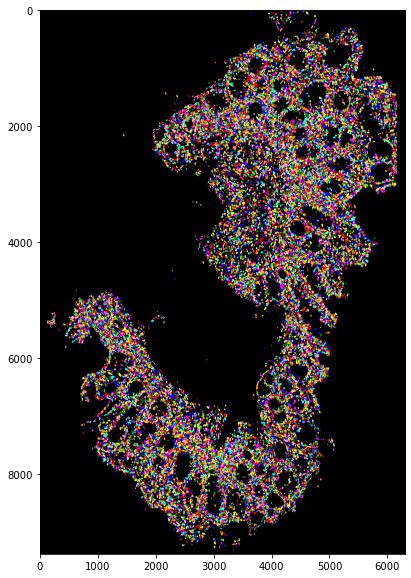

In [26]:
mask = np.loadtxt('../../data/CellDive/results/GI6645_mask.csv')
fig_size(10, 16)
plt.imshow(sk.color.label2rgb(mask, bg_label=0));


## JPR 125

In [27]:
%%time 
img, channels = read_img('/n/scratch3/users/i/ik97/JPR_125_43_region_001.ome.tiff')


CPU times: user 46.4 s, sys: 7.05 s, total: 53.4 s
Wall time: 53.9 s


In [28]:
# %%time 
# plot_rgb(img[:, 1000:, :], ['CD90', 'PDPN', 'DAPI_INIT'], channels)


In [ ]:
%%time
do_pipeline(
    img[: , 1000:, :], 
    libname = 'JPR125',
    channels = channels, 
    channels_dna = ['DAPI_FINAL'], ## DAPI_FINAL reflects viable cells at the end of experiment 
    channels_cells = [
        'ASMA', 'CD146', 'CD3', 'CD31', 'CD4', 'CD45',
        'CD68', 'CD8', 'PDGFRA', 'PDPN', 'VIM'
    ],
    outdir = '/n/scratch3/users/i/ik97/results/',
    min_dna_intensity = 1e9
)


    row_start  row_end  col_start  col_end
0           0     2048          0     2048
1           0     2048       2048     4096
2           0     2048       4096     6144
3           0     2048       6144     8192
4           0     2048       8192    10240
5           0     2048      10240    12288
6        2048     4096          0     2048
7        2048     4096       2048     4096
8        2048     4096       4096     6144
9        2048     4096       6144     8192
10       2048     4096       8192    10240
11       2048     4096      10240    12288
12       4096     6144          0     2048
13       4096     6144       2048     4096
14       4096     6144       4096     6144
15       4096     6144       6144     8192
16       4096     6144       8192    10240
17       4096     6144      10240    12288
18       6144     8192          0     2048
19       6144     8192       2048     4096
20       6144     8192       4096     6144
21       6144     8192       6144     8192
22       61

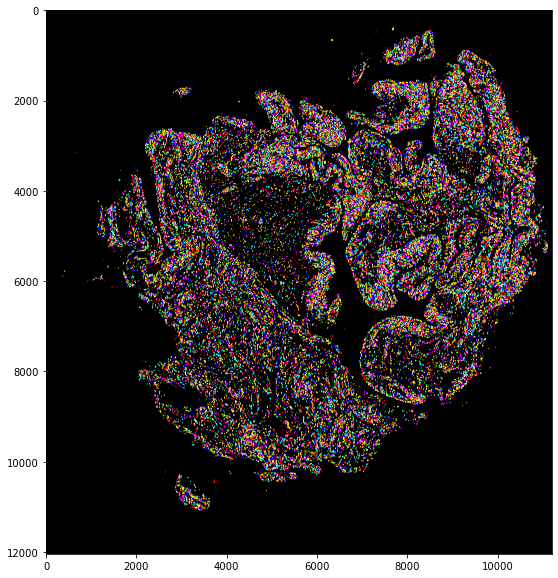

In [8]:
mask = np.loadtxt('../../data/CellDive/results/JPR125_mask.csv')
fig_size(10, 16)
plt.imshow(sk.color.label2rgb(mask, bg_label=0));


## JPR 118

In [ ]:
%%time 
img, channels = read_img('/n/scratch3/users/i/ik97/JPR_118_4_region_001.ome.tiff')


In [ ]:
# %%time 
# plot_rgb(img[:, :, :], ['CD90', 'PDPN', 'DAPI_INIT'], channels)


In [ ]:
%%time
do_pipeline(
    img, 
    libname = 'JPR118',
    channels = channels, 
    channels_dna = ['DAPI_FINAL'], ## DAPI_FINAL reflects viable cells at the end of experiment 
    # channels_dna = ['DAPI_INIT', 'DAPI_FINAL'],
    channels_cells = [
        'ASMA', 'CD146', 'CD3', 'CD31', 'CD4', 'CD45',
        'CD68', 'CD8',
        'PDGFRA', 'PDPN', 'VIM'
    ],
    outdir = '/n/scratch3/users/i/ik97/results/',
    min_dna_intensity = 1e9
)


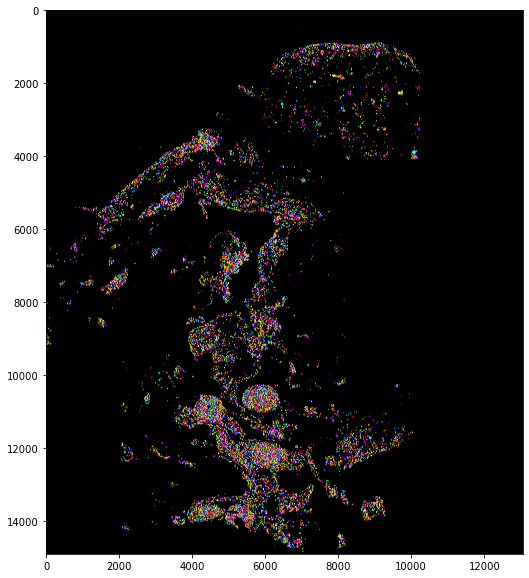

In [9]:
mask = np.loadtxt('../../data/CellDive/results/JPR118_mask.csv')
fig_size(10, 16)
plt.imshow(sk.color.label2rgb(mask, bg_label=0));


## S445185

In [ ]:
%%time 
img, channels = read_img('/n/scratch3/users/i/ik97/S445185_region_001.ome.tiff')


In [ ]:
# %%time 
# plot_rgb(img[:, :, :], ['CK8', 'VIM', 'DAPI_INIT'], channels)


In [ ]:
%%time
do_pipeline(
    img, 
    libname = 'S445185',
    channels = channels, 
    channels_dna = ['DAPI_FINAL'],
    channels_cells = [
        'ASMA', 'CD146', 'CD3', 'CD31', 'CD4', 'CD45', 'CD68',
        'CD8', 'CD90', 'CK8', 'PDGFRA', 'PDPN', 'VIM'    
    ],
    outdir = '/n/scratch3/users/i/ik97/results/'
)

In [ ]:
mask = np.loadtxt('../../data/CellDive/results/S445185_mask.csv')
fig_size(10, 16)
plt.imshow(sk.color.label2rgb(mask, bg_label=0));


## S445250

In [ ]:
%%time 
img, channels = read_img('/n/scratch3/users/i/ik97/S445250_region_001.ome.tiff')


In [ ]:
%%time 
plot_rgb(img[:, :, :], ['CK8', 'VIM', 'DAPI_FINAL'], channels)


In [ ]:
%%time
do_pipeline(
    img, 
    libname = 'S445250',
    channels = channels, 
    channels_dna = ['DAPI_FINAL'],
    channels_cells = [
        'ASMA', 'CD146', 'CD3', 'CD31', 'CD4', 'CD45', 'CD68',
        'CD8', 'CD90', 'CK8', 'PDGFRA', 'PDPN', 'VIM'    
    ],
    outdir = '/n/scratch3/users/i/ik97/results/'
)


In [ ]:
mask = np.loadtxt('../../data/CellDive/results/S445250_mask.csv')
fig_size(10, 16)
plt.imshow(sk.color.label2rgb(mask, bg_label=0));


## BS18

### Channels

In [4]:
img_fname = '/n/scratch3/users/i/ik97/BS18A03667_A2_4_region_001.ome.tiff'
tif = TiffFile(img_fname)
root = ET.fromstring(tif.ome_metadata)
channels_bs18 = [i.items()[1][1] for i in root.iter() if re.search('Channel', i.tag)]


### Images

In [6]:
fnames = [i for i in os.listdir('/n/scratch3/users/i/ik97/') if re.match('BS18.*R\\d.*ome.tiff', i)]
fnames

['BS18A03667_R1_x17924_y14571.ome.tiff',
 'BS18A03667_R2_x1112_y2947.ome.tiff',
 'BS18A03667_R3_x23372_y916.ome.tiff',
 'BS18A03667_R4_13867_y2938.ome.tiff',
 'BS18A03667_R5_x5294_y14571.ome.tiff']

In [ ]:
%%time
for fname in fnames:
    print('----------------', fname, '----------------')
    img, _ = read_img('/n/scratch3/users/i/ik97/{}'.format(fname))
    print(img.shape)
    do_pipeline(
        img, 
        libname = fname.strip('.ome.tiff'),
        channels = channels_bs18, 
        channels_dna = ['DAPI_FINAL'], ## DAPI_FINAL reflects viable cells at the end of experiment 
        channels_cells = [
            'ASMA', 'CD146', 'CD3', 'CD31', 'CD4', 'CD45', 'CD68',
            'CD8', 'CD90', 'CK8', 'PDGFRA', 'PDPN', 'VIM'
        ],
        outdir = '/n/scratch3/users/i/ik97/results/',
        min_dna_intensity = 1e9
    )


### Masks

In [ ]:
# mask = np.loadtxt('../../data/CellDive/results/S445250_mask.csv')
# fig_size(10, 16)
# plt.imshow(sk.color.label2rgb(mask, bg_label=0));


## BS17

### Channels

In [4]:
img_fname = '/n/scratch3/users/i/ik97/BS17D69381_B2_4_region_001.ome.tiff'
tif = TiffFile(img_fname)
root = ET.fromstring(tif.ome_metadata)
channels_bs17 = [i.items()[1][1] for i in root.iter() if re.search('Channel', i.tag)]
channels_bs17

['DAPI_INIT',
 'DAPI_FINAL',
 'ASMA',
 'CCL19',
 'CD11C',
 'CD146',
 'CD3',
 'CD31',
 'CD4',
 'CD45',
 'CD68',
 'CD8',
 'CD90',
 'CDH11',
 'CK8',
 'HLADR',
 'MERTK',
 'PANCADHERIN',
 'PDGFRA',
 'PDPN',
 'PSTAT1',
 'SPARC',
 'VIM']

### Images

In [5]:
fnames = [i for i in os.listdir('/n/scratch3/users/i/ik97/') if re.match('BS17.*R\\d.*ome.tiff', i)]
fnames

['BS17D69381_R1_x36_y1853.ome.tiff',
 'BS17D69381_R2_x14621_y33253.ome.tiff',
 'BS17D69381_R3_x20098_y16904.ome.tiff',
 'BS17D69381_R4_x7292_y16904.ome.tiff',
 'BS17D69381_R5_x12354_y0.ome.tiff']

In [10]:
# [i for i in os.listdir('/n/scratch3/users/i/ik97/results') if re.match('BS17.*mask', i)]
fnames = ['BS17D69381_R3_x20098_y16904.ome.tiff',
'BS17D69381_R4_x7292_y16904.ome.tiff',
'BS17D69381_R5_x12354_y0.ome.tiff']

In [11]:
%%time
for fname in fnames:
    print('----------------', fname, '----------------')
    img, _ = read_img('/n/scratch3/users/i/ik97/{}'.format(fname))
    print(img.shape)
    do_pipeline(
        img, 
        libname = fname.strip('.ome.tiff'),
        channels = channels_bs17, 
        channels_dna = ['DAPI_FINAL'], ## DAPI_FINAL reflects viable cells at the end of experiment 
        channels_cells = [
            'ASMA', 'CD146', 'CD3', 'CD31', 'CD4', 'CD45', 'CD68',
            'CD8', 'CD90', 'CK8', 'PDGFRA', 'PDPN', 'VIM'
        ],
        outdir = '/n/scratch3/users/i/ik97/results/',
        min_dna_intensity = 1e9
    )


---------------- BS17D69381_R3_x20098_y16904.ome.tiff ----------------
(23, 16349, 16002)
    row_start  row_end  col_start  col_end
0           0     2048          0     2048
1           0     2048       2048     4096
2           0     2048       4096     6144
3           0     2048       6144     8192
4           0     2048       8192    10240
..        ...      ...        ...      ...
59      14336    16384       6144     8192
60      14336    16384       8192    10240
61      14336    16384      10240    12288
62      14336    16384      12288    14336
63      14336    16384      14336    16384

[64 rows x 4 columns]


2022-02-27 12:09:37.419418: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-27 12:09:37.420771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla M40 computeCapability: 5.2
coreClock: 1.112GHz coreCount: 24 deviceMemorySize: 11.18GiB deviceMemoryBandwidth: 268.58GiB/s
2022-02-27 12:09:37.422483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2022-02-27 12:09:37.422544: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-27 12:09:38.206937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor w

0 ---------------------------


2022-02-27 12:09:54.603005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-27 12:09:54.603887: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299910000 Hz
2022-02-27 12:09:55.769562: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-02-27 12:09:56.104936: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-02-27 12:09:57.396642: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-27 12:09:57.670534: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


1 ---------------------------
2 ---------------------------
3 ---------------------------
4 ---------------------------
5 ---------------------------
6 ---------------------------
7 ---------------------------
8 ---------------------------
9 ---------------------------
10 ---------------------------
11 ---------------------------
12 ---------------------------
13 ---------------------------
14 ---------------------------
15 ---------------------------
16 ---------------------------
17 ---------------------------
18 ---------------------------
19 ---------------------------
20 ---------------------------
21 ---------------------------
22 ---------------------------
23 ---------------------------
24 ---------------------------
25 ---------------------------
26 ---------------------------
27 ---------------------------
28 ---------------------------
29 ---------------------------
30 ---------------------------
31 ---------------------------
32 ---------------------------
33 --------------

# Re-process

Maybe the CLAHE expression values introduce more noise than signal. Let's summarize the raw intensities instead. 


## BS18

In [ ]:
# img_fname = '/n/scratch3/users/i/ik97/BS18A03667_A2_4_region_001.ome.tiff'
# tif = TiffFile(img_fname)
# root = ET.fromstring(tif.ome_metadata)
# channels = [i.items()[1][1] for i in root.iter() if re.search('Channel', i.tag)]


# %%time
# mask = np.loadtxt('/home/ik97/Roche/data/CellDive/results/BS18A03667_R1_x17924_y14571_mask.csv', dtype='int')

# %%time 
# img, _ = read_img('/n/scratch3/users/i/ik97/BS18A03667_R1_x17924_y14571.ome.tiff')


# %%time 
# metadata, intensity = quant_cells(mask, img, channels)


# outdir = '/n/scratch3/users/i/ik97/'
# libname='BS18A03667_R1_x17924_y14571'
# metadata.to_csv('{}/{}_metadata_raw.csv'.format(outdir, libname))
# intensity.to_csv('{}/{}_intensity_raw.csv'.format(outdir, libname))
